<a href="https://colab.research.google.com/github/zzappa/diy_mtob/blob/main/diy_mtob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evaluate cer rouge_score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=d5aed13b0b2977b8b94a83b54e1b1ea6d7adbe31d1b223cfd448a7cff162d897

In [ ]:
import pandas as pd
import evaluate
from typing import Mapping
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class EvalWrapper:
    def __init__(self):
        self.metrics: Mapping[str, tuple[evaluate.EvaluationModule, dict]] = {
            'rouge': (evaluate.load("rouge"), dict()),
            'bleu': (evaluate.load("bleu"), dict()),
            'chrf': (evaluate.load("chrf"), dict()),
            'character': (evaluate.load("character"), dict()),
        }

    def __call__(self, preds: list[str], refs: list[str]):
        return {
            name: metric.compute(predictions=preds, references=refs, **kwargs)
            for name, (metric, kwargs) in self.metrics.items()
        }

def evaluate_translations(input_file: str, test_columns: list[str], output_dir: str = 'evaluation_results'):
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True, parents=True)

    df = pd.read_csv(input_file)

    evaluator = EvalWrapper()

    all_results = {}

    for test_col in test_columns:
        print(f"Evaluating {test_col}...")

        inputs = df['original'].tolist()
        preds = df[test_col].tolist()
        refs = df['ground truth'].tolist()

        valid_indices = [i for i in range(len(preds))
                        if pd.notna(preds[i]) and pd.notna(refs[i]) and pd.notna(inputs[i])]

        clean_inputs = [inputs[i] for i in valid_indices]
        clean_preds = [str(preds[i]) for i in valid_indices]
        clean_refs = [str(refs[i]) for i in valid_indices]

        results = evaluator(preds=clean_preds, refs=clean_refs)

        results.update({
            'test_column': test_col,
            'num_examples': len(clean_preds),
            'num_original_examples': len(preds),
            'num_dropped_examples': len(preds) - len(clean_preds)
        })

        all_results[test_col] = results

        output_file = output_path / f"{test_col}---eval.json"
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=4)
            print(f'Saved {test_col} results to {output_file}')

    combined_output = output_path / "combined_results.json"
    with open(combined_output, 'w') as f:
        json.dump(all_results, f, indent=4)
        print(f'Saved combined results to {combined_output}')

    return all_results

In [ ]:
filename = "ke_en_12_models.csv"
input_path = f"/content/{filename}"

In [ ]:
ans = pd.read_csv(input_path)

In [ ]:
ans.columns

Index(['original', 'ground truth', 'claude 3.5 (Gs + W + S)',
       'claude 3.5 (Gm)', 'chatgpt 4o (Gs)', 'chatgpt 4o (G + W)',
       'chatgpt o1-preview (Gs) (25 Nov)', 'chatgpt o1 (Gm + W + S) (9 Dec)',
       'gemini 1.5 pro (G + W)', 'gemini 1.5 pro (G + W + S) (25 Nov)',
       'gemini 1.5 pro (G + W + S) (9 Dec)',
       'gemini 2.0 flash exp (G + W + S)', 'Llama 3.2 90B (Gs + S)',
       'DeepSeek V3 (Gm + S)'],
      dtype='object')

In [ ]:
test_columns = [
    'claude 3.5 (Gs + W + S)', 'claude 3.5 (Gm)',
    'chatgpt 4o (Gs)', 'chatgpt 4o (G + W)', 'chatgpt o1-preview (Gs) (25 Nov)', 'chatgpt o1 (Gm + W + S) (9 Dec)',
    'gemini 1.5 pro (G + W)', 'gemini 1.5 pro (G + W + S) (25 Nov)', 'gemini 1.5 pro (G + W + S) (9 Dec)', 'gemini 2.0 flash exp (G + W + S)',
    'Llama 3.2 90B (Gs + S)',
    'DeepSeek V3 (Gm + S)'
    ]
results = evaluate_translations(input_path, test_columns)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Evaluating claude 3.5 (Gs + W + S)...
Saved claude 3.5 (Gs + W + S) results to evaluation_results/claude 3.5 (Gs + W + S)---eval.json
Evaluating claude 3.5 (Gm)...
Saved claude 3.5 (Gm) results to evaluation_results/claude 3.5 (Gm)---eval.json
Evaluating chatgpt 4o (Gs)...
Saved chatgpt 4o (Gs) results to evaluation_results/chatgpt 4o (Gs)---eval.json
Evaluating chatgpt 4o (G + W)...
Saved chatgpt 4o (G + W) results to evaluation_results/chatgpt 4o (G + W)---eval.json
Evaluating chatgpt o1-preview (Gs) (25 Nov)...
Saved chatgpt o1-preview (Gs) (25 Nov) results to evaluation_results/chatgpt o1-preview (Gs) (25 Nov)---eval.json
Evaluating chatgpt o1 (Gm + W + S) (9 Dec)...
Saved chatgpt o1 (Gm + W + S) (9 Dec) results to evaluation_results/chatgpt o1 (Gm + W + S) (9 Dec)---eval.json
Evaluating gemini 1.5 pro (G + W)...
Saved gemini 1.5 pro (G + W) results to evaluation_results/gemini 1.5 pro (G + W)---eval.json
Evaluating gemini 1.5 pro (G + W + S) (25 Nov)...
Saved gemini 1.5 pro (G + W


Model Performance Results:

Percentage Scores:
                                      BLEU   chrF
claude 3.5 (Gs + W + S)              23.16  50.98
claude 3.5 (Gm)                       8.08  35.68
chatgpt 4o (Gs)                       0.00  19.33
chatgpt 4o (G + W)                    5.97  22.32
chatgpt o1-preview (Gs) (25 Nov)     14.69  40.69
chatgpt o1 (Gm + W + S) (9 Dec)      21.17  47.87
gemini 1.5 pro (G + W)               14.96  42.40
gemini 1.5 pro (G + W + S) (25 Nov)  23.08  50.02
gemini 1.5 pro (G + W + S) (9 Dec)   20.72  48.86
gemini 2.0 flash exp (G + W + S)     15.95  41.49
Llama 3.2 90B (Gs + S)               14.29  37.41
DeepSeek V3 (Gm + S)                 14.02  41.89


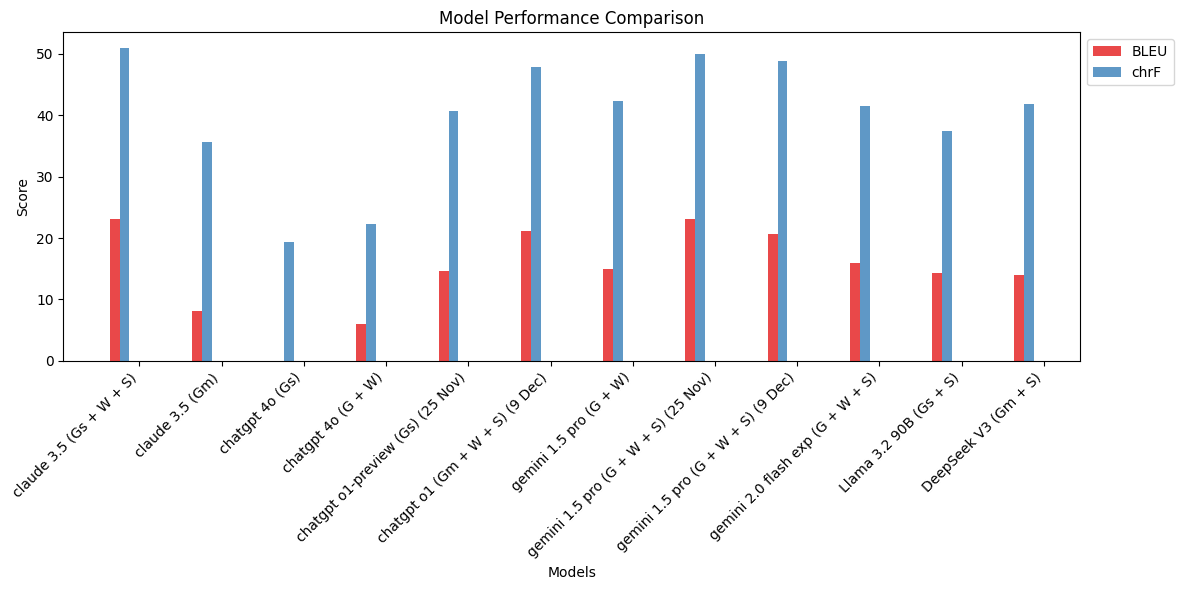

In [ ]:
with open('/content/evaluation_results/combined_results.json', 'r') as f:
    results = json.load(f)

metrics_data = {
    model: {
        # 'ROUGE-1': data['rouge']['rouge1'] * 100,
        # 'ROUGE-2': data['rouge']['rouge2'] * 100,
        # 'ROUGE-L': data['rouge']['rougeL'] * 100,
        'BLEU': data['bleu']['bleu'] * 100,
        'chrF': data['chrf']['score'],
        # 'CER': data['character']['cer_score'] * 100
    }
    for model, data in results.items()
}

df = pd.DataFrame(metrics_data).T

plt.figure(figsize=(12, 6))

bar_width = 0.12
opacity = 0.8
index = np.arange(len(df.index))

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']

for idx, column in enumerate(df.columns):
    plt.bar(index + idx * bar_width,
            df[column],
            bar_width,
            alpha=opacity,
            color=colors[idx % len(colors)],
            label=column)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width * 2.5, df.index, rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.savefig('/content/evaluation_results/model_comparison.png', bbox_inches='tight', dpi=300)

print("\nModel Performance Results:")
print("\nPercentage Scores:")
print(df.round(2).to_string())

df.round(2).to_csv('/content/evaluation_results/model_comparison.csv')


Metric-Grouped Performance Results:

Percentage Scores:
      claude 3.5 (Gs + W + S)  claude 3.5 (Gm)  chatgpt 4o (Gs)  chatgpt 4o (G + W)  chatgpt o1-preview (Gs) (25 Nov)  chatgpt o1 (Gm + W + S) (9 Dec)  gemini 1.5 pro (G + W)  gemini 1.5 pro (G + W + S) (25 Nov)  gemini 1.5 pro (G + W + S) (9 Dec)  gemini 2.0 flash exp (G + W + S)  Llama 3.2 90B (Gs + S)  DeepSeek V3 (Gm + S)
BLEU                    23.16             8.08             0.00                5.97                             14.69                            21.17                   14.96                                23.08                               20.72                             15.95                   14.29                 14.02
chrF                    50.98            35.68            19.33               22.32                             40.69                            47.87                   42.40                                50.02                               48.86                             41.49      

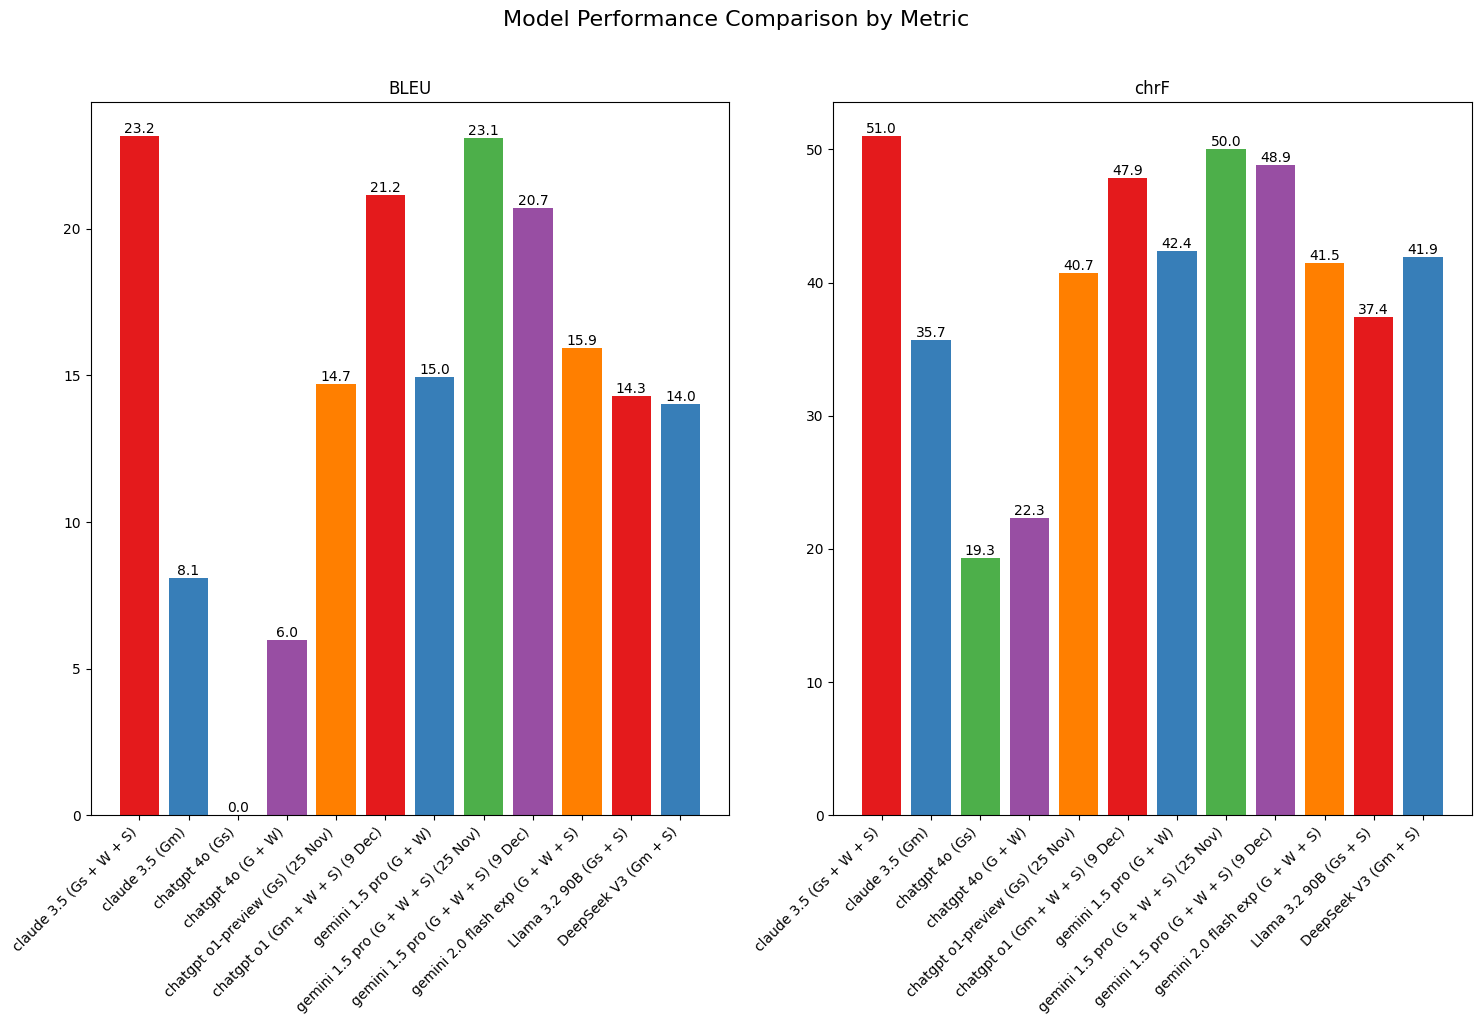

In [ ]:
with open('/content/evaluation_results/combined_results.json', 'r') as f:
    results = json.load(f)

metrics_data = {
    model: {
        # 'ROUGE-1': data['rouge']['rouge1'] * 100,
        # 'ROUGE-2': data['rouge']['rouge2'] * 100,
        # 'ROUGE-L': data['rouge']['rougeL'] * 100,
        'BLEU': data['bleu']['bleu'] * 100,
        'chrF': data['chrf']['score'],
        # 'CER': data['character']['cer_score'] * 100
    }
    for model, data in results.items()
}

df = pd.DataFrame(metrics_data)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))  # change it if more metrics are used
fig.suptitle('Model Performance Comparison by Metric', fontsize=16, y=1.02)

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

axs_flat = axs.flatten()

for idx, (metric, scores) in enumerate(df.iterrows()):
    ax = axs_flat[idx]
    bars = ax.bar(range(len(scores)), scores, color=colors)
    ax.set_title(metric)
    ax.set_xticks(range(len(scores)))
    ax.set_xticklabels(scores.index, rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')

plt.tight_layout()

plt.savefig('/content/evaluation_results/metric_grouped_comparison.png', bbox_inches='tight', dpi=300)

print("\nMetric-Grouped Performance Results:")
print("\nPercentage Scores:")
print(df.round(2).to_string())

rankings = pd.DataFrame(index=df.index, columns=df.columns)
for metric in df.index:
    if metric == 'CER':
        rankings.loc[metric] = df.loc[metric].rank(ascending=True)
    else:
        rankings.loc[metric] = df.loc[metric].rank(ascending=False)

print("\nModel Rankings by Metric (1 is best):")
print(rankings.round(0).to_string())

df.round(2).to_csv('/content/evaluation_results/metric_grouped_comparison.csv')
rankings.round(0).to_csv('/content/evaluation_results/model_rankings.csv')

print("\nOverall Model Performance Summary:")
for model in df.columns:
    avg_rank = rankings[model].mean()
    print(f"\n{model}:")
    print(f"Average Rank: {avg_rank:.2f}")
    print("Best Metrics:", ", ".join(df.index[rankings[model] == 1].tolist()))
    print("Worst Metrics:", ", ".join(df.index[rankings[model] == len(df.columns)].tolist()))